<a href="https://colab.research.google.com/github/Nolanole/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

## Use a subset of the data

Predict **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

In [0]:
mask = ((df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
        (df['SALE_PRICE'] > 100000) & 
        (df['SALE_PRICE'] < 2000000))

df = df[mask]

## Do train/test split

Use data from January — March 2019 to train. Use data from April 2019 to test.

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3151
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [0]:
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((2507, 21), (644, 21))

In [0]:
import pandas_profiling
train.profile_report()

## BONUS: Exploratory visualizations with Seaborn

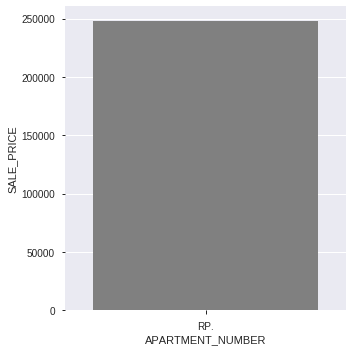

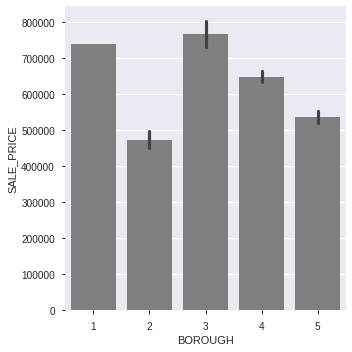

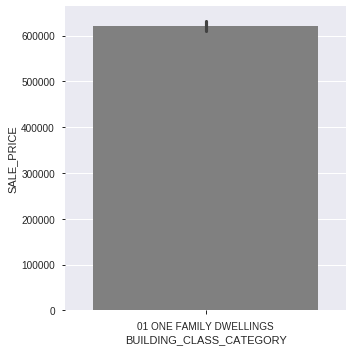

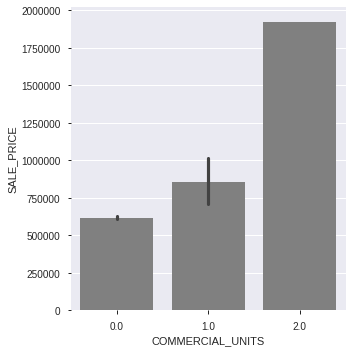

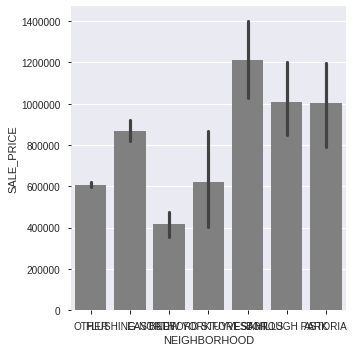

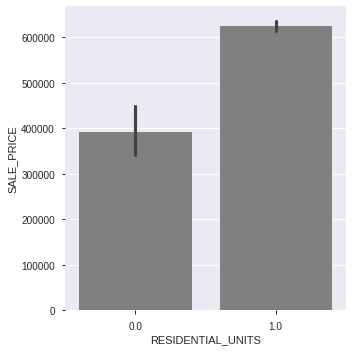

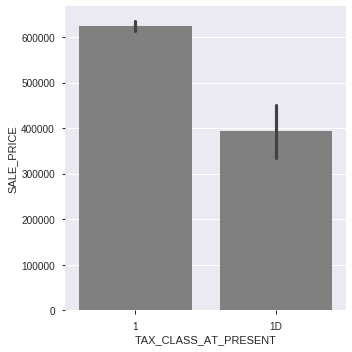

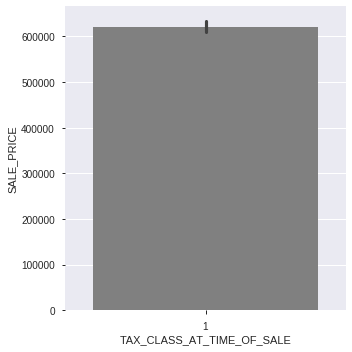

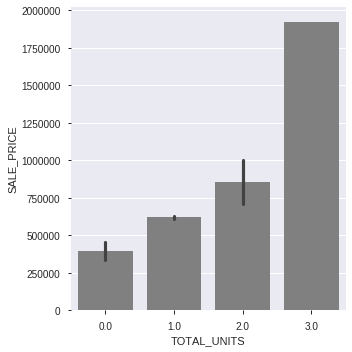

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

for col in sorted(train.columns):
    if train[col].nunique() < 10:
        try:
            sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
            plt.show()
        except:
            pass

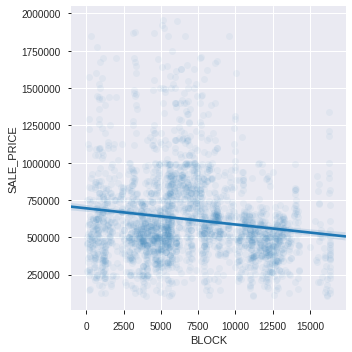

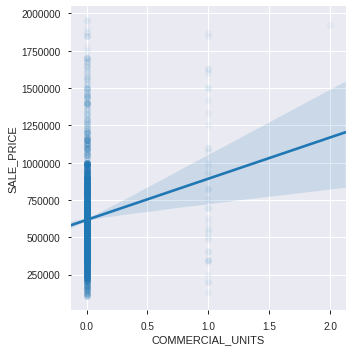

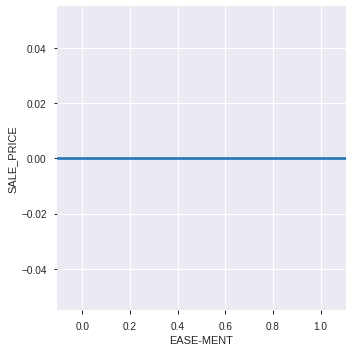

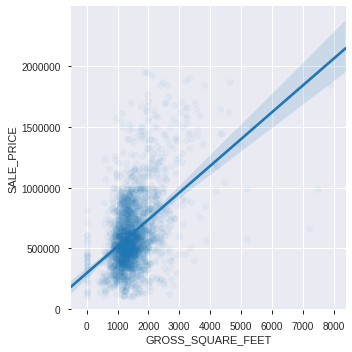

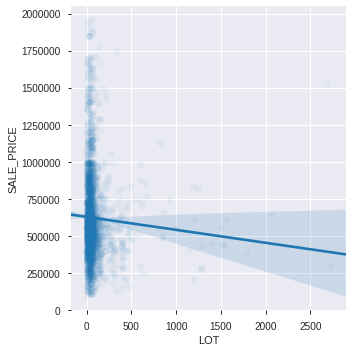

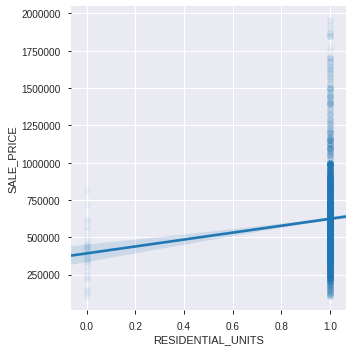

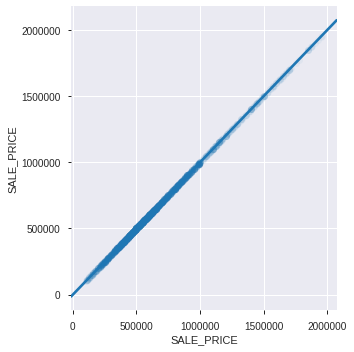

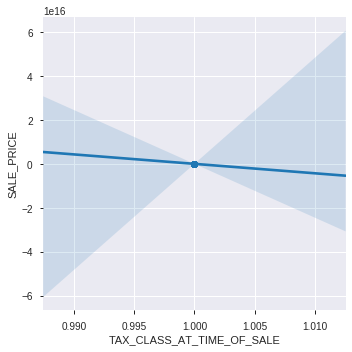

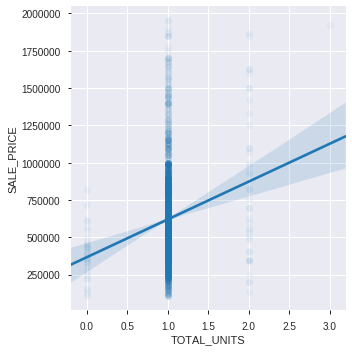

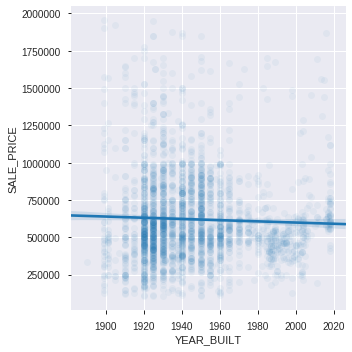

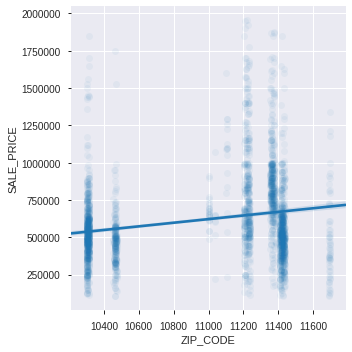

In [0]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

## Do one-hot encoding of categorical features

In [0]:
# Check cardinality of non-numeric features
train.describe(exclude='number').T.sort_values(by='unique')

count unique  ...      first       last
BUILDING_CLASS_CATEGORY         2507      1  ...        NaT        NaT
APARTMENT_NUMBER                   1      1  ...        NaT        NaT
TAX_CLASS_AT_PRESENT            2507      2  ...        NaT        NaT
BOROUGH                         2507      5  ...        NaT        NaT
NEIGHBORHOOD                    2507      7  ...        NaT        NaT
BUILDING_CLASS_AT_TIME_OF_SALE  2507     11  ...        NaT        NaT
BUILDING_CLASS_AT_PRESENT       2507     13  ...        NaT        NaT
SALE_DATE                       2507     68  ... 2019-01-01 2019-03-30
LAND_SQUARE_FEET                2507    887  ...        NaT        NaT
ADDRESS                         2507   2497  ...        NaT        NaT

[10 rows x 6 columns]

In [0]:
target = 'SALE_PRICE'
numerics = train.select_dtypes(include='number').columns.drop(target).tolist()
categoricals = train.select_dtypes(exclude='number').columns.tolist()
low_cardinality_categoricals = [col for col in categoricals
                               if train[col].nunique() <= 50]

features = numerics + low_cardinality_categoricals


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

X_train_encoded.head()

BLOCK  ...  BUILDING_CLASS_AT_TIME_OF_SALE_S0
44    5495  ...                                  0
61    7918  ...                                  0
78    4210  ...                                  0
108   5212  ...                                  0
111   7930  ...                                  0

[5 rows x 51 columns]

## BONUS: Fit a linear regression model with multiple features. Get mean absolute error for the test set.

Notice that the errors blow up!

In [0]:
# Drop EASE-MENT, it's null 100% of the time
X_train_encoded = X_train_encoded.drop(columns='EASE-MENT')
X_test_encoded = X_test_encoded.drop(columns='EASE-MENT')

In [0]:
# Filter these warnings:
# sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered
# scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='sklearn')
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='scipy')

In [0]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $183,641 

2 features
Test MAE: $182,569 

3 features
Test MAE: $182,569 

4 features
Test MAE: $183,441 

5 features
Test MAE: $186,532 

6 features
Test MAE: $176,121 

7 features
Test MAE: $177,001 

8 features
Test MAE: $176,707 

9 features
Test MAE: $170,969 

10 features
Test MAE: $170,977 

11 features
Test MAE: $170,507 

12 features
Test MAE: $162,301 

13 features
Test MAE: $163,559 

14 features
Test MAE: $162,562 

15 features
Test MAE: $162,550 

16 features
Test MAE: $162,678 

17 features
Test MAE: $162,419 

18 features
Test MAE: $162,177 

19 features
Test MAE: $162,177 

20 features
Test MAE: $157,893 

21 features
Test MAE: $157,966 

22 features
Test MAE: $157,966 

23 features
Test MAE: $157,966 

24 features
Test MAE: $157,630 

25 features
Test MAE: $157,580 

26 features
Test MAE: $25,968,990,575,776,280 

27 features
Test MAE: $157,550 

28 features
Test MAE: $87,300,193,986,380,608 

29 features
Test MAE: $158,491 

30 features
Test MAE: 

In [0]:
# What's going on with k=26?
k = 26
print(f'{k} features')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f} \n')

# Which features were selected?
all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]

pd.options.display.float_format = '{:,.0f}'.format
pd.Series(model.coef_, selected_names)

26 features
Test MAE: $25,968,990,575,776,280 



BLOCK                                                  -97,035
ZIP_CODE                                              -152,985
COMMERCIAL_UNITS                    -4,115,324,664,197,034,496
TOTAL_UNITS                         -2,872,516,607,892,124,160
GROSS_SQUARE_FEET                                      123,739
BOROUGH_3                                              146,876
BOROUGH_4                                              197,262
BOROUGH_2                                              -55,917
BOROUGH_5                                              -84,107
NEIGHBORHOOD_OTHER                                      56,036
NEIGHBORHOOD_FLUSHING-NORTH                             63,394
NEIGHBORHOOD_FOREST HILLS                               46,411
NEIGHBORHOOD_BOROUGH PARK                               29,915
TAX_CLASS_AT_PRESENT_1D               -545,831,543,721,722,112
BUILDING_CLASS_AT_PRESENT_A5                            -1,673
BUILDING_CLASS_AT_PRESENT_A3             5,516,361,218,

## Fit a ridge regression model with multiple features. Get mean absolute error for the test set.


In [0]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = RidgeCV()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $183,670 

2 features
Test MAE: $182,607 

3 features
Test MAE: $182,605 

4 features
Test MAE: $183,452 

5 features
Test MAE: $181,936 

6 features
Test MAE: $176,477 

7 features
Test MAE: $176,975 

8 features
Test MAE: $176,672 

9 features
Test MAE: $171,669 

10 features
Test MAE: $170,980 

11 features
Test MAE: $170,525 

12 features
Test MAE: $162,283 

13 features
Test MAE: $163,497 

14 features
Test MAE: $162,504 

15 features
Test MAE: $162,505 

16 features
Test MAE: $162,360 

17 features
Test MAE: $162,360 

18 features
Test MAE: $162,116 

19 features
Test MAE: $162,116 

20 features
Test MAE: $157,841 

21 features
Test MAE: $157,909 

22 features
Test MAE: $157,651 

23 features
Test MAE: $157,652 

24 features
Test MAE: $157,584 

25 features
Test MAE: $157,535 

26 features
Test MAE: $157,515 

27 features
Test MAE: $157,505 

28 features
Test MAE: $157,582 

29 features
Test MAE: $158,448 

30 features
Test MAE: $158,545 

31 features
Test MA

In [0]:
# Which features were used?
k = 27
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0

Features not selected:
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_